In [1]:
import os
os.chdir('/data3.5T/S312112030/DeepTTA')

print(os.getcwd())

FileNotFoundError: [Errno 2] No such file or directory: '/data3.5T/S312112030/DeepTTA'

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator

In [3]:
tcga_df = pd.read_csv("../data/TCGA/TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt", sep='\t', index_col=0)
ccle_df = pd.read_csv("../data/CCLE/CCLE_exp_476samples_4692genes.txt", sep='\t', index_col=0)

In [4]:
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)

In [5]:
get_data_value_range(tcga_df,"TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt")
get_data_value_range(ccle_df,"CCLE_exp_476samples_4692genes.txt")
get_data_value_range(AUC_df,"Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv")

TCGA_exp_matchCCLEgenes_8238samples_4692genes.txt : 
Range: 17.54320000
Minimum: 0.00000000
Maximum: 17.54320000
Mean: 3.14438322
Median: 2.95240000
Standard Deviation: 2.19230416
Skewness: 0.66413397
binary data:False
-------------------------------------
CCLE_exp_476samples_4692genes.txt : 
Range: 15.03066714
Minimum: 0.00000000
Maximum: 15.03066714
Mean: 2.60725793
Median: 2.22342255
Standard Deviation: 2.34870610
Skewness: 0.69443208
binary data:False
-------------------------------------
Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv : 
Range: 0.99582593
Minimum: 0.00417407
Maximum: 1.00000000
Mean: 0.80430513
Median: 0.84956918
Standard Deviation: 0.16005942
Skewness: -1.63872677
binary data:False
-------------------------------------


In [6]:
AUC_dropNAN=AUC_df.values.ravel()
AUC_dropNAN = AUC_dropNAN[~np.isnan(AUC_dropNAN)]
print(len(AUC_dropNAN))

391740


In [7]:
AUC_dropNAN_log2= np.log2(AUC_dropNAN+1) # np.log2(AUC_dropNAN+1)
# epsilon = 1e-6  # Small constant to handle zeros
# AUC_dropNAN_log2 = np.log(AUC_dropNAN_log2 + epsilon)

In [9]:
get_data_value_range(AUC_dropNAN_log2,"log(-log2) Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv")

log(-log2) Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv : 
Range: 0.99399063
Minimum: 0.00600937
Maximum: 1.00000000
Mean: 0.84503063
Median: 0.88718926
Standard Deviation: 0.14052874
Skewness: -2.07319616
binary data:False
-------------------------------------


In [18]:
plt.figure(figsize=(8, 6))

# Prepare data for boxplot
data = [tcga_df.values.ravel(), ccle_df.values.ravel()]
labels = ['TCGA', 'CCLE']
        
sns.boxplot(data=data, palette=['blue', 'red'], linewidth=1.5)
plt.xticks(ticks=[0, 1], labels=labels, fontsize=12)
plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Expression Values', fontsize=16)
plt.title('Boxplot of Expression Values', fontsize=16)

plt.show()

: 

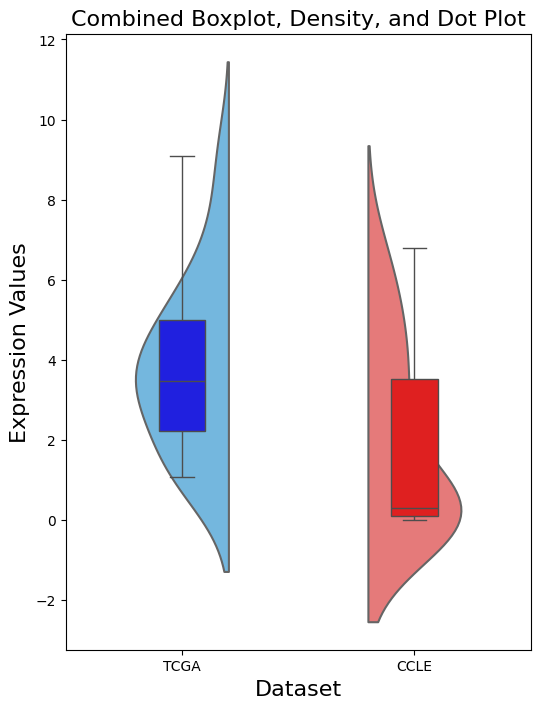

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example data
np.random.seed(42)
tcga_data = tcga_df.values.ravel()
ccle_data = ccle_df.values.ravel()

# Prepare DataFrame
data = pd.DataFrame({
    'Value': np.concatenate([tcga_data[:20], ccle_data[:20]]),
    'Dataset': ['TCGA'] * len(tcga_data[:20]) + ['CCLE'] * len(ccle_data[:20])
})

# Create the plot
plt.figure(figsize=(6, 8))
sns.violinplot(data=data, x='Dataset', y='Value', hue='Dataset', palette=['#62bcf0','#f76868' ], split=True,gap=0.5, inner=None, linewidth=1.5,legend=False)
sns.boxplot(data=data, x='Dataset', y='Value', hue='Dataset', width=0.2, palette=['blue','red'], showfliers=True,legend=False)
# sns.stripplot(data=data, x='Dataset', y='Value', jitter=True, palette=['#f76868', '#62bcf0'], alpha=0.5)


# Customize labels and legend
plt.xlabel('Dataset', fontsize=16)
plt.ylabel('Expression Values', fontsize=16)
plt.title('Combined Boxplot, Density, and Dot Plot', fontsize=16)
plt.show()

/tmp/ipykernel_21010/2949329696.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Dataset', y='Value', data=df, inner=None, linewidth=2,split=True,gap=0.2,cut=0,


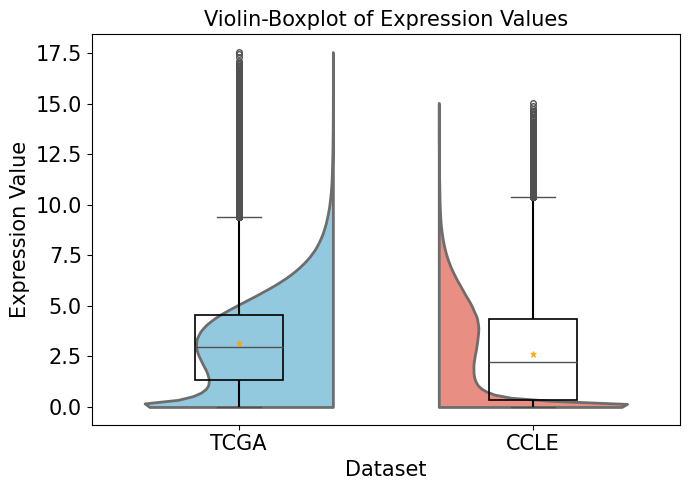

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

tcga_data = tcga_df.values.ravel()
ccle_data = ccle_df.values.ravel()
data = pd.DataFrame({
    'Value': np.concatenate([tcga_data, ccle_data]),
    'Dataset': ['TCGA'] * len(tcga_data) + ['CCLE'] * len(ccle_data)
})

df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(7, 5))
sns.violinplot(x='Dataset', y='Value', data=df, inner=None, linewidth=2,split=True,gap=0.2,cut=0,
    palette={'TCGA': 'skyblue', 'CCLE': 'salmon'})
flierprops = dict(marker='o', markersize=4, markeredgewidth=1, markerfacecolor='none')
meanprops={"marker": "*", "markersize":5, "markerfacecolor": "#faa507", "markeredgecolor": "#faa507", "markeredgewidth": 0.5}
sns.boxplot(x='Dataset', y='Value', data=df, width=0.3, showmeans=True,meanprops=meanprops,
    boxprops={'facecolor': 'none','linewidth': 1.2, 'edgecolor': 'k'}, showfliers=True,flierprops=flierprops,whiskerprops={'linewidth': 1.5, 'color': 'k'})

# # Add significance marker
#plt.text(0.5, 0.28, '*', fontsize=20, ha='center', va='bottom')

# Customize the plot
plt.ylabel('Expression Value', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('Dataset', fontsize=15)
plt.title('Violin-Boxplot of Expression Values', fontsize=15)
plt.tight_layout()

# Show the plot
plt.show()

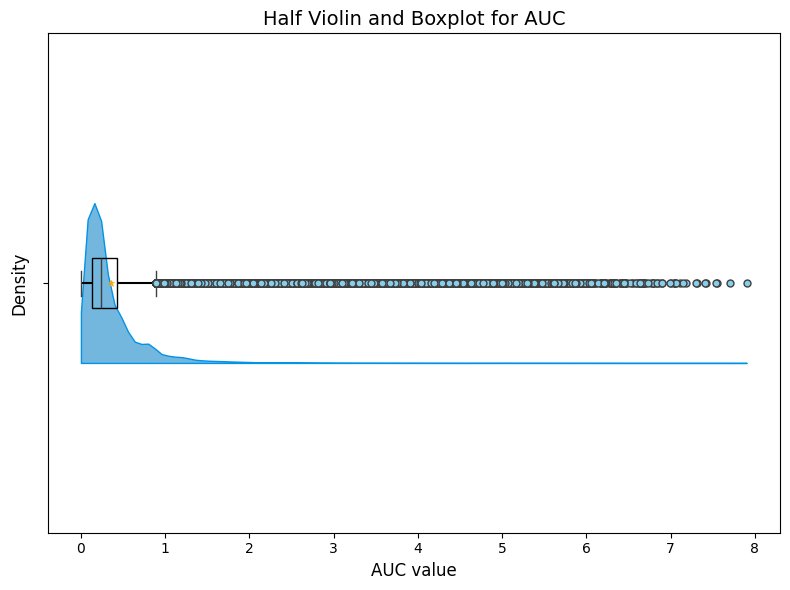

In [10]:

# Create a DataFrame with a single condition
data = {
    'Sample': [f'Sample{i+1}' for i in range(len(AUC_dropNAN_log2))],
    'Expression_Level': AUC_dropNAN_log2,
    'Condition': [' '] * len(AUC_dropNAN_log2)  # Single condition for all samples
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Expression_Level', orient='h', y='Condition', hue='Condition', legend=False,split=True,gap =0.6, data=df, inner=None, palette=['#62bcf0'], cut=0, linewidth=1,edgecolor='#0292e6')
flierprops = dict(marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue')
meanprops={"marker": "*", "markersize":5, "markerfacecolor": "#faa507", "markeredgecolor": "#faa507", "markeredgewidth": 0.5}
sns.boxplot(x='Expression_Level', orient='h', y='Condition', data=df, width=0.1, showcaps=True, boxprops={'facecolor': 'none', 'edgecolor': 'k'}, 
     showfliers=True,flierprops=flierprops,whiskerprops={'linewidth': 1.5, 'color': 'k'}, showmeans=True,meanprops=meanprops)
# sns.stripplot(x='Expression_Level', y='Condition', data=df, color='#b6e1fa', size=0.1, jitter=True)

# Customize the plot
plt.ylabel('Density', fontsize=12)
plt.xlabel('AUC value', fontsize=12)
plt.title('Half Violin and Boxplot for AUC', fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_21010/3075550817.py:17: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0)
/tmp/ipykernel_21010/3075550817.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot( AUC_dropNAN, fill=True, palette="#62bc50", linewidth=2,cut=0)


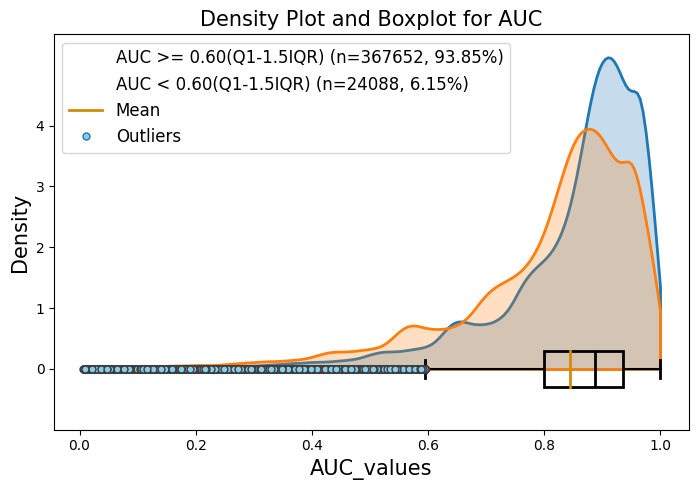

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.lines import Line2D
# Assuming AUC_df is already defined
data = {
    'Sample': [f'Sample{i+1}' for i in range(len(AUC_dropNAN_log2))],
    'AUC_values': AUC_dropNAN_log2,
    'Condition': [' '] * len(AUC_dropNAN_log2)  # Single condition for all samples
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(7, 5))

# Replace violin plot with a density plot (KDE plot)
sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0)

# Add the boxplot
# Set the properties for the outlier dots in the boxplot
flierprops = dict(marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue')
sns.boxplot(AUC_dropNAN_log2, 
            orient='h', 
            width=0.6, 
            showcaps=True, 
            boxprops={'facecolor': 'none','linewidth': 2, 'edgecolor': 'k'}, 
            medianprops={'linewidth': 2, 'color': 'k'},                  
            showfliers=True, 
            flierprops=flierprops, 
            whiskerprops={'linewidth': 1.5, 'color': 'k'}, 
            showmeans=True,
            meanline=True,
            capprops={'linewidth': 2, 'color': 'k'},
            meanprops={"linestyle":'-', "linewidth":2, "color":'#d48b04'}  # Blue mean line similar to Q2
            )
# 計算 Q1, Q3 和 IQR
Q1 = np.percentile(df['AUC_values'], 25)
Q3 = np.percentile(df['AUC_values'], 75)
IQR = Q3 - Q1
threshold = Q1 - 1.5 * IQR # Q3 + 1.5 * IQR # Q1- 1.5 * IQR 

# Calculate data counts for threshold
auc_greater_than_threshold = df[df['AUC_values'] >= threshold].shape[0]
auc_less_than_threshold = df[df['AUC_values'] < threshold].shape[0]
total = auc_greater_than_threshold + auc_less_than_threshold
# Q3+1.5IQR Q1-1.5IQR 
legend_elements = [
    Line2D([0], [0], color='none', label=f'AUC >= {threshold:.2f}(Q1-1.5IQR) (n={auc_greater_than_threshold}, {(auc_greater_than_threshold / total * 100):.2f}%)'),
    Line2D([0], [0], color='none', label=f'AUC < {threshold:.2f}(Q1-1.5IQR) (n={auc_less_than_threshold}, {(auc_less_than_threshold / total * 100):.2f}%)'),
    Line2D([0], [0], color='#d48b04', lw=2, linestyle='solid', label='Mean'),
    Line2D([0], [0], marker='o', markersize=5, markeredgewidth=1, markerfacecolor='skyblue', label='Outliers', linestyle='None'),
  ]
plt.legend(handles=legend_elements, loc='upper left', fontsize=12)

# Customize the plot
plt.ylabel('Density', fontsize=15)
plt.xlabel('AUC_values', fontsize=15)
plt.title('Density Plot and Boxplot for AUC', fontsize=15)
plt.tight_layout()
plt.ylim(-1, 5.5) #
plt.yticks(range(0, 5),[str(y) for y in range(0, 5)]) # Ensure ticks are shown
# Show the plot
plt.show()

/tmp/ipykernel_21010/3269258989.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0, label='log2(AUC+1)')
/tmp/ipykernel_21010/3269258989.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot( AUC_dropNAN, fill=True, palette="#62bc50", linewidth=2,cut=0, label='AUC')


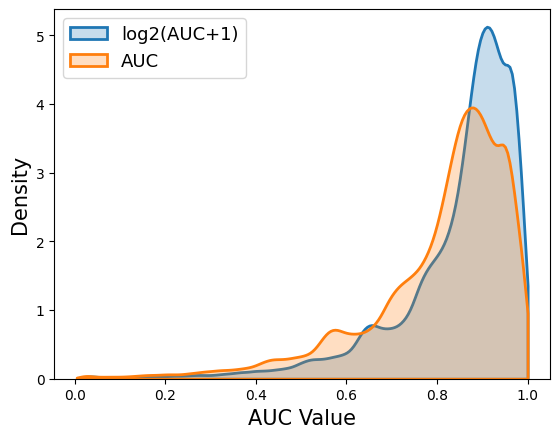

In [38]:
sns.kdeplot( AUC_dropNAN_log2, fill=True, palette="#62bcf0", linewidth=2,cut=0, label='log2(AUC+1)')
sns.kdeplot( AUC_dropNAN, fill=True, palette="#62bc50", linewidth=2,cut=0, label='AUC')
plt.legend(loc='upper left', fontsize=13)
plt.xlabel('AUC Value', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.show()

(0.0, 0.05]      484
(0.05, 0.1]      417
(0.1, 0.15]      443
(0.15, 0.2]      609
(0.2, 0.25]      878
(0.25, 0.3]     1033
(0.3, 0.35]     1320
(0.35, 0.4]     1954
(0.4, 0.45]     2399
(0.45, 0.5]     3383
(0.5, 0.55]     5434
(0.55, 0.6]     6385
(0.6, 0.65]    11401
(0.65, 0.7]    14709
(0.7, 0.75]    16886
(0.75, 0.8]    30114
(0.8, 0.85]    42526
(0.85, 0.9]    80621
(0.9, 0.95]    96531
(0.95, 1.0]    74213
Name: count, dtype: int64


/tmp/ipykernel_21010/1575193660.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['count'] = df.groupby('AUC_range').size()


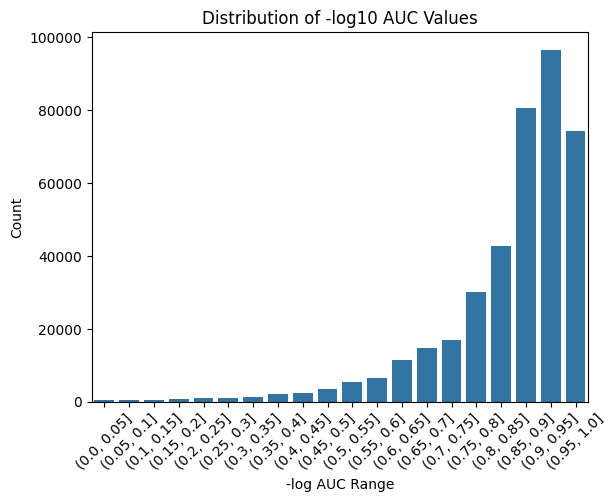

In [45]:

auc_values = AUC_dropNAN_log2

# 將 AUC 值分組，每組間隔 0.05
bins = np.arange(0, 1.02, 0.05)

categories = pd.cut(auc_values, bins, right=True) #right=True(]; right=False[)

# Calculate the count for each bin
bin_counts = categories.value_counts().sort_index()

# Print the count of each interval
print(bin_counts)

# 計算每個區間的數量
df = pd.DataFrame({'AUC_range': categories})
df['count'] = df.groupby('AUC_range').size()


# 使用 Seaborn繪製條形圖
sns.countplot(x='AUC_range', data=df)
plt.xticks(rotation=45)
plt.xlabel('-log AUC Range')
plt.ylabel('Count')

plt.title('Distribution of -log10 AUC Values')
plt.show()

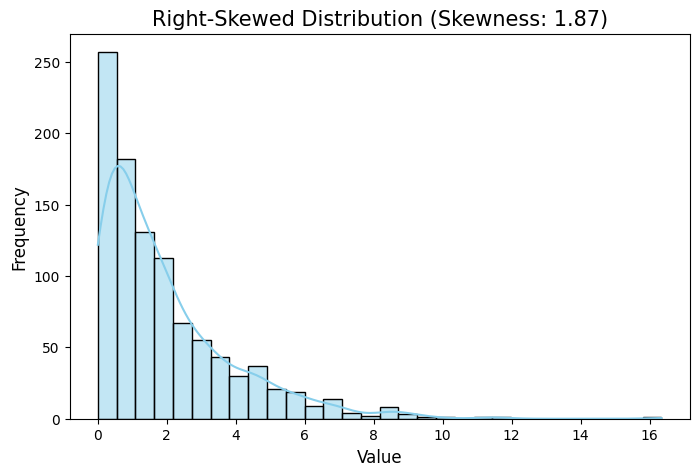

(array([0.93853618, 6.02024286, 2.63349139, 1.82588511, 0.33924974,
        0.33919258, 0.11967754, 4.02246173, 1.83816431, 2.46250012]),
 1.865034222864843)

In [67]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
np.random.seed(42)
# Generate a right-skewed array using an exponential distribution
right_skewed_array = np.random.exponential(scale=2.0, size=1000)

# Calculate the skewness
calculated_skewness = skew(right_skewed_array)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.histplot(right_skewed_array, kde=True, color='skyblue', bins=30)
plt.title(f"Right-Skewed Distribution (Skewness: {calculated_skewness:.2f})", fontsize=15)
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.show()

right_skewed_array[:10], calculated_skewness

In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util

from utils.ESPF_drug2emb import drug2emb_encoder
from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset
from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density,Density_Plot_of_AUC_Values
from utils.tools import get_data_value_range,set_seed,get_vram_usage
from utils.Metrics import MetricsCalculator

In [31]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [34]:
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalHuberLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp

test = True #False, True: batch_size = 3, num_epoch = 2, full dataset

omics_files = {
    'Mut': "../data/CCLE/CCLE_match_TCGAgene_PRISMandEXPsample_binary_mutation_476_6009.txt",
    'Exp': "../data/CCLE/CCLE_exp_476samples_4692genes.txt",
    # Add more omics types and paths as needed
    }
omics_dict = {'Mut':0,'Exp':1,'CN':2, 'Eff':3, 'Dep':4, 'Met':5}
omics_data_dict = {}
omics_data_tensor_dict = {}
omics_numfeatures_dict = {}
omics_encode_dim_dict ={'Mut':[1000,100,50],'Exp':[1000,100,50], # Dr.Chiu:exp[500,200,50]
                        'CN':[100,50,30], 'Eff':[100,50,30], 'Dep':[100,50,30], 'Met':[100,50,30]}

TCGA_pretrain_weight_path_dict = {'Mut': "./results/Encoder_tcga_mut_1000_100_50_best_loss_0.0066.pt",
                                  'Exp': "./results/Encoder_tcga_exp_1000_100_50_best_loss_0.7.pt",
                                  # Add more omics types and paths as needed
                                }
seed = 42
#hyperparameter
model_name = "Omics_DrugESPF_Model" # Omics_DrugESPF_Model  Omics_DCSA_Model
AUCtransform = None #"-log2"
splitType= 'byCCL' # byCCL byDrug
kfoldCV = 2
include_omics = ['Exp']
max_drug_len=50 # 不夠補零補到50 / 超過取前50個subwords(index) !!!!須改方法!!!! 
drug_embedding_feature_size = 128
ESPF = True # False True
Drug_SelfAttention = False
pos_emb_type = 'sinusoidal' # 'learned' 'sinusoidal'
#需再修改-----------

intermediate_size =512
num_attention_heads = 8        
attention_probs_dropout_prob = 0.1
hidden_dropout_prob = 0.1

if ESPF is True:
    
    drug_encode_dims =[1600,400,100] # 50*128  
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
elif ESPF is False:
    
    drug_encode_dims =[110,55,22]
    dense_layer_dim = sum(omics_encode_dim_dict[omic_type][2] for omic_type in include_omics) + drug_encode_dims[2] # MLPDim
#需再修改-------------
TrackGradient = False # False True

activation_func = nn.ReLU()  # ReLU activation function # Leaky ReLu
activation_func_final = nn.Sigmoid() # ScaledSigmoid(scale=8) GroundT range ( 0 ~ scale ) # ReLU_clamp(max=8)
#nn.Sigmoid()or ReLU() or Linear/identity(when -log2AUC)
batch_size = 200
num_epoch = 200 # for k fold CV 
patience = 20
warmup_iters = 60
Decrease_percent = 0.9
continuous = True
learning_rate=1e-04
#criterion = Custom_LossFunction(loss_type="MSE", loss_lambda=1.0, regular_type=None, regular_lambda=1e-06) #nn.MSELoss()#
criterion =  FocalHuberLoss(delta=0.5, alpha=1.0, gamma=2.0, regular_type=None, regular_lambda=1e-05)

hyperparameter_print = f' omics_dict ={omics_dict}\n omics_files ={omics_files}\n TCGA_pretrain_weight_path_dict ={TCGA_pretrain_weight_path_dict}\n seed ={seed}\n  model_name ={model_name}\n AUCtransform ={AUCtransform}\n splitType ={splitType}\n kfoldCV ={kfoldCV}\n omics_encode_dim ={[(omic_type,omics_encode_dim_dict[omic_type]) for omic_type in include_omics]}\n max_drug_len ={max_drug_len}\n drug_embedding_feature_size ={drug_embedding_feature_size}\n ESPF ={ESPF}\n Drug_SelfAttention ={Drug_SelfAttention}\n pos_emb_type ={pos_emb_type}\n intermediate_size ={intermediate_size}\n num_attention_heads ={num_attention_heads}\n attention_probs_dropout_prob ={attention_probs_dropout_prob}\n hidden_dropout_prob ={hidden_dropout_prob}\n drug_encode_dims ={drug_encode_dims}\n dense_layer_dim = {dense_layer_dim}\n activation_func = {activation_func}\n activation_func_final = {activation_func_final}\n batch_size = {batch_size}\n num_epoch = {num_epoch}\n patience = {patience}\n warmup_iters = {warmup_iters}\n Decrease_percent = {Decrease_percent}\n continuous ={continuous}\n learning_rate = {learning_rate}\n criterion ={criterion}\n'

__translation_table__ = str.maketrans({
    "*": "",    "/": "",    ":": "-",    "%": "",
    "'": "",    "\"": "",    "[": "",    "]": "",
    ",": "" })

hyperparameter_folder_part = (f'Model{model_name}_{splitType}_Omics{[omic_type for omic_type in include_omics]}_ESPF{ESPF}_Tranformer{Drug_SelfAttention}').translate(__translation_table__)




In [ ]:

set_seed(seed)
for omic_type in include_omics:
    # Read the file
    omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep='\t', index_col=0)

    if test is True:
        # Specify the index as needed
        omics_data_dict[omic_type] = omics_data_dict[omic_type][:76]  # Adjust the row selection as needed  
    if omic_type == "Exp":# apply Column-wise Min-Max Normalization 
        scaler = MinMaxScaler() 
        omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)

    omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_tensor_dict[omic_type].shape[1]
 
    print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])

Exp tensor shape: torch.Size([76, 4692])
Exp num_features 4692


In [44]:
drug_df= pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/MACCS(Secondary_Screen_treatment_info)_union_NOrepeat.csv", sep=',', index_col=0)
AUC_df = pd.read_csv("../data/no_Imputation_PRISM_Repurposing_Secondary_Screen_data/Drug_sensitivity_AUC_(PRISM_Repurposing_Secondary_Screen)_subsetted_NOrepeat.csv", sep=',', index_col=0)
# matched AUCfile and omics_data samples
matched_samples = sorted(set(AUC_df.T.columns) & set(list(omics_data_dict.values())[0].T.columns))

AUC_df= (AUC_df.T[matched_samples]).T

print("AUC_df",AUC_df.shape)
if AUCtransform == "-log2":
    AUC_df = -np.log2(AUC_df)
if AUCtransform == "-log10":
    AUC_df = -np.log10(AUC_df)
    
print("drug_df",drug_df.shape)
print("AUC_df",AUC_df.shape)

AUC_df (76, 1440)
drug_df (1440, 9)
AUC_df (76, 1440)


In [ ]:
if test is True:
    batch_size = 3
    num_epoch = 2
    print("batch_size",batch_size,"num_epoch:",num_epoch)
    drug_df=drug_df[:42]
    AUC_df=AUC_df.iloc[:76,:42]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
    kfoldCV = 2
    print("kfoldCV",kfoldCV)


if 'weighted' in criterion.loss_type :    
    # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
    weighted_threshold = np.nanpercentile(AUC_df.values, 90)    
    total_samples = (~np.isnan(AUC_df.values)).sum().item()
    fewWt_samples = (AUC_df.values > weighted_threshold).sum().item()
    moreWt_samples = total_samples - fewWt_samples
    few_weight = total_samples / (2 * fewWt_samples)  
    more_weight = total_samples / (2 * moreWt_samples)   
    # print("weighted_threshold",weighted_threshold)
    # print("total_samples",total_samples)
    # print("few_samples",few_samples)
    # print("more_samples",more_samples)
    # print("few_weight",few_weight)
    # print("more_weight",more_weight)
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
print("weighted_threshold:",weighted_threshold)

batch_size 3 num_epoch: 2
drug_df (42, 9)
AUC_df (0, 42)
kfoldCV 2


In [41]:
if ESPF is True:
    drug_smiles =drug_df["smiles"] # 
    drug_names =drug_df.index
    # 挑出重複的SMILES
    duplicate =  drug_smiles[drug_smiles.duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_encode = pd.Series(drug_smiles).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_encode = drug_df["MACCS166bits"]
    drug_encode_list = [list(map(int, item.split(','))) for item in drug_encode.values]
    print("MACCS166bits_drug_encode_list type: ",type(drug_encode_list))
    drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_encode.shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)

# Convert your data to tensors if they're in numpy
response_matrix_tensor = torch.tensor(AUC_df.values, dtype=torch.float32).to(device)


num_ccl,num_drug:  476 1440


In [42]:
if kfoldCV>1:
    id_unrepeat_test, id_unrepeat_train_val = split_id(num_ccl,num_drug,splitType,kfoldCV,repeat=True)
    # repeat the test id
    if splitType == "byCCL":
        repeatNum = num_drug
    elif splitType == "byDrug":
        repeatNum = num_ccl
    id_test = repeat_func(id_unrepeat_test, repeatNum, setname='test')

id_unrepeat_train (380,)
id_unrepeat_val (48,)
id_unrepeat_test (48,)
id_unrepeat_train_val (428,)
id_test.shape (69120,)


In [43]:
print(id_test[:10])

[10080 10081 10082 10083 10084 10085 10086 10087 10088 10089]


In [44]:
set_seed(seed)
dataset = OmicsDrugDataset(omics_data_tensor_dict, drug_features_tensor, response_matrix_tensor, splitType, include_omics)

test_dataset = Subset(dataset, id_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) # , num_workers=4, pin_memory=True
# #create whole dataset
# whole_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [ ]:
%%time
# Evaluation
val_epoch_loss_list=None
if model_name == "Omics_DrugESPF_Model":
    model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
elif model_name == "Omics_DCSA_Model":
    model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                        drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                        TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
model.to(device=device)

best_weight = "./results/BestFold3_test_loss0.0483043_BestValEpo18_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_DrugSelfAttentionFalse/BestValWeight.pt"
# best_weight = "./results/BestFold0_test_loss0.0472113_BestValEpo18_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_TranformerFalse/BestValWeight.pt"
# best_weight = "./results/BestFold2_test_loss0.0479106_BestValEpo37_ModelOmics_DCSA_Model_byCCL_OmicsExp_ESPFTrue_TranformerFalse/BestValWeight.pt"

model.load_state_dict(torch.load(best_weight))

model_outputs = evaluation(model, val_epoch_loss_list, criterion, test_loader, device,ESPF,Drug_SelfAttention, weighted_threshold, few_weight, more_weight, outputcontrol='inference')
# eval_targets, eval_outputs,predAUCwithUnknownGT, AttenScorMat_DrugCellSelf,eval_outputs_before_final_activation_list
test_targets, test_outputs,predAUCwithUnknownGT, AttenScorMat_DrugCellSelf,test_outputs_before_final_activation_list=model_outputs[0],model_outputs[1],model_outputs[2],model_outputs[3],model_outputs[4]


State_dict for Sequential(
  (0): Linear(in_features=4692, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=50, bias=True)
  (5): ReLU()
) loaded successfully.

 Drug_SelfAttention is not applied 

CPU times: user 3.03 s, sys: 0 ns, total: 3.03 s
Wall time: 2.58 s


In [46]:
print("test_targets\n",test_targets[0][:10])
print("test_outputs_before_final_activation_list\n",test_outputs_before_final_activation_list[0][:10])
print("test_outputs\n",test_outputs[0][:10])

test_targets
 [0.07083898 0.11802737 0.76182055 0.08739668 0.21962953 0.05212169
 0.12588584 0.10243527 0.2536405  0.21010098]
test_outputs_before_final_activation_list
 [-4.347802  -4.3079147 -2.3843443 -4.763396  -3.5471814 -4.5777965
 -3.422064  -4.4056907 -3.6082757 -3.8508327]
test_outputs
 [0.10216022 0.10626227 0.6749947  0.06771452 0.22399344 0.08138373
 0.25290382 0.09648354 0.21106862 0.1665549 ]


In [47]:
metrics_calculator = MetricsCalculator()
test_metrics= metrics_calculator.compute_all_metrics(np.concatenate(test_targets), np.concatenate(test_outputs),set_name='test_set')
metrics_calculator.print_results(set_name='test_set')

Evaluation test_set
{'Evaluation': 'test_set', 'RMSE': 0.21633406, 'MAE': 0.12019241, 'R^2': 0.7511016279459}


In [14]:
# if splitType == "byCCL":
#     id_unrepeat_whole = list(range(476))
# elif splitType == "byDrug":
#     id_unrepeat_whole = list(range(1440))
#     id_unrepeat_whole[:10], id_unrepeat_whole[-10:]  # Display the first and last 10 elements to confirm

In [48]:
# Correlation
test_pearson, test_spearman,test_AllSameValuesList_count  = correlation_func(splitType, AUC_df.values,AUC_df.index,AUC_df.columns,id_unrepeat_test,test_targets,test_outputs)

Text(0.5, 0.98, 'Density Plot of Correlation Omics_DCSA_Model')

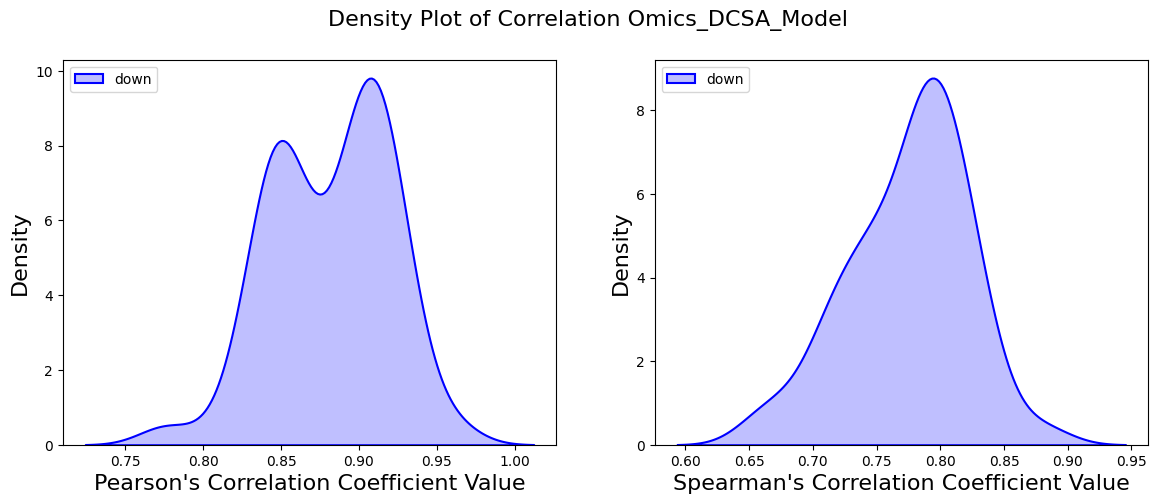

In [49]:
#pearson
# Create a density plot using seaborn's kdeplot function
fig=plt.figure(figsize=(14, 5))
# Set the title of the plot

plt.subplot(1,2,1)
# sns.kdeplot(test_pearson1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(test_pearson, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Pearson\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 

plt.subplot(1,2,2)
#spearman
# Create a density plot using seaborn's kdeplot function
# sns.kdeplot(test_spearman1, fill=True, color='red', label='up',linewidth=1.5)
sns.kdeplot(test_spearman, fill=True, color='blue', label='down',linewidth=1.5)
# Set the x-axis label to 'Density'
plt.xlabel('Spearman\'s Correlation Coefficient Value', fontsize=16)
# Set the y-axis label to 'Pearson\'s Correlation Coefficient Value'
plt.ylabel('Density', fontsize=16)
plt.legend(loc='upper left',fontsize=10) 
fig.suptitle(f'Density Plot of Correlation {model_name}', fontsize=16)

In [ ]:
# for name, pearson in [("Test", test_pearson1)]:
#     print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
# for name, spearman in [("Test", test_spearman1)]:
#     print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")

for name, pearson in [("Test", test_pearson)]:
    print(f"Mean Median Mode {name} Pearson {model_name}:\t{np.mean(pearson):.6f} ± {np.std(pearson):.4f}\t{stats.skew(pearson, bias=False, nan_policy='raise'):.6f}\t {np.median(pearson):.6f}\t{stats.mode(np.round(pearson,2))}\n")
for name, spearman in [("Test", test_spearman)]:
    print(f"Mean Median Mode {name} Spearman {model_name}:\t{np.mean(spearman):.6f} ± {np.std(spearman):.4f}\t{stats.skew(spearman, bias=False, nan_policy='raise'):.6f}\t {np.median(spearman):.6f}\t{stats.mode(np.round(spearman,2))}\n")


Mean Median Mode Test Pearson Omics_DCSA_Model:	0.881552 ± 0.0372	-0.360584	 0.888646	ModeResult(mode=0.85, count=9)

Mean Median Mode Test Spearman Omics_DCSA_Model:	0.774816 ± 0.0458	-0.464838	 0.785637	ModeResult(mode=0.79, count=8)



<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

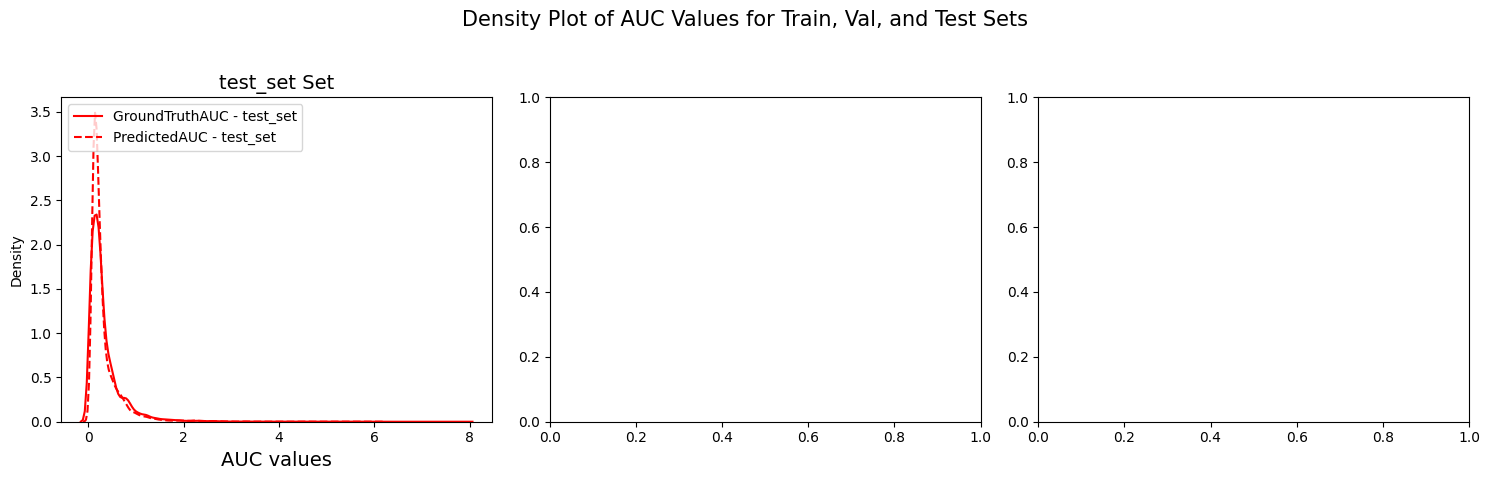

In [51]:
datas = [(test_targets, test_outputs, 'test_set', 'red')]
# plot Density_Plot_of_AUC_Values of train val test datasets
hyperparameter_folder_path = None
Density_Plot_of_AUC_Values(datas,hyperparameter_folder_path)

array([-2.857317 , -3.2015917, -1.4904466, -2.1182692, -2.2079132,
       -1.7585391, -1.780536 , -3.857124 , -2.831453 , -2.4521768],
      dtype=float32)